In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Path rephraser 
def path_rephraser(path: str) -> str:
    return path.replace('\\', '/')

#print(rephrased_path)  # Output: C:/Users/jj402/Desktop/ML
# Rephrase the file path

path = r"C:\Users\jj402\Desktop\ML\loan_default_ml\data\application_train.csv"
rephrased_path = path_rephraser(path)

# Load the dataset
data = pd.read_csv(rephrased_path)

In [4]:
# Missing values table and the mean 
# Identify the null values in each column, find the mean of the missing null values and convert to percentage and then solve it with worst offenders first.

missing_pct = (data.isnull().mean() * 100).sort_values(ascending=False)
# remove columns with 0% missing values

missing_pct = missing_pct[missing_pct > 0.0]

# Filtering the columns related to housing details like 'COMMONAREA_AVG' for combining the housing missingness indicator

housing_columns = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG']
housing_cols = []

for i in housing_columns: # Removing the subscript 'AVG' in all the columns
    if i.endswith('_AVG'):
        z = i.replace('_AVG','_') 
        housing_cols.append(z)

housing_columns = [ # storing all the housing details related columns with different subscripts like 'AVG', 'MODE', etc
    col for col in data.columns
    if col.startswith(tuple(housing_cols))
]

# Addition of the missingness indicator for all the features related to housing details

data['housing_info_missing'] = (
    data[housing_columns].isnull().all(axis=1)
).astype(int)

#data['housing_info_missing'].value_counts(normalize=True)

# Missingness indicators for external sources
data['EXT_SOURCE_1_missing'] = data['EXT_SOURCE_1'].isnull().astype(int)
data['EXT_SOURCE_3_missing'] = data['EXT_SOURCE_3'].isnull().astype(int)
data['EXT_SOURCE_3_missing'] = data['EXT_SOURCE_3'].isnull().astype(int)

# Credit enquiry details missingness indicators
credit_enquiry_cols = [
    col for col in data.columns
    if col.startswith('AMT_REQ_CREDIT_BUREAU')
]

data['Credit_info_missing'] = (
    data[credit_enquiry_cols].isnull().all(axis=1).astype(int)
)

data['OCCUPATION_TYPE'] = data['OCCUPATION_TYPE'].fillna('Not_Applicable') 
# Not adding a missing flag for this case instead encoding a new category for not applicable for unemployed or pensioners


# New features based on credit ratios 
data['credit_income_ratio'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['annuity_income_ratio'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['employment_age_ratio'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

data.replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\jj402\AppData\Local\Temp\ipykernel_37072\2397488074.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['housing_info_missing'] = (
C:\Users\jj402\AppData\Local\Temp\ipykernel_37072\2397488074.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['EXT_SOURCE_1_missing'] = data['EXT_SOURCE_1'].isnull().astype(int)
C:\Users\jj402\AppData\Local\Temp\ipykernel_37072\2397488074.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,housing_info_missing,EXT_SOURCE_1_missing,EXT_SOURCE_3_missing,Credit_info_missing,credit_income_ratio,annuity_income_ratio,employment_age_ratio
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,1.0,0,0,0,0,2.007889,0.121978,0.067329
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0,0,1,0,4.790750,0.132217,0.070862
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,1,1,0,0,2.000000,0.100000,0.011814
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,1,1,1,1,2.316167,0.219900,0.159905
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,1,1,1,0,4.222222,0.179963,0.152418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,0,0,1,1,1.617143,0.174971,0.025303
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,0,1,1,1,3.743750,0.166687,-17.580890
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,1.0,0.0,1.0,0,0,0,0,4.429176,0.195941,0.529266
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0.0,0.0,0.0,0,1,0,0,2.164368,0.118158,0.400134


In [5]:
#Splitting the dataset into training and testing sets

y = data['TARGET']
X = data.drop(columns=['TARGET'])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state= 42, stratify= y)

if y_train.value_counts(normalize=True).all() == y_test.value_counts(normalize=True).all():
    print("\nBoth the splits are same\n") 
else : 
    print("\nBoth the sets are not same\n")


Both the splits are same



In [6]:
# Splitting the numerical columns and categorical columns separately for imputation 

num_cols = X_train.select_dtypes(include = ['int64','float64']).columns
cat_cols = X_train.select_dtypes(include = ['str']).columns

# Preprocessing Imputer pipelines are defined for numeric and categorical values separately

numeric_pipeline_wo_scal = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_pipeline = Pipeline( steps = [
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])

# Definition of the Preprocessor block using the imputer pipelines 

preprocessor_tree = ColumnTransformer(
    transformers = [
        ('num', numeric_pipeline_wo_scal, num_cols),
        ('cat', categorical_pipeline, cat_cols)
    ]
)

In [7]:
evaluation_df = pd.DataFrame(columns=[
        "model_name",
        "roc_auc",
        "recall", 
        "precision",
        "f1_score"
    ])


In [8]:
# Training a random forest classifier model after adding class weight

from sklearn.ensemble import RandomForestClassifier

rf_model_2 = Pipeline(steps=[
    ('preprocessor',preprocessor_tree),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        min_samples_leaf=50,
        n_jobs=1,
        random_state=42,        
        class_weight='balanced'
    ))
])


In [9]:
# Setup of the k-fold cross-validation
cv = StratifiedKFold(
    n_splits=5,
    shuffle= True,
    random_state=42
)

rf_cv_scores_base = cross_val_score(
    rf_model_2, 
    X_train,
    y_train, 
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

rf_cv_scores_base, rf_cv_scores_base.mean(), rf_cv_scores_base.std()

(array([0.72527721, 0.72899127, 0.72982154, 0.72683988, 0.72347298]),
 np.float64(0.7268805757511123),
 np.float64(0.0023361704562258525))

In [10]:
# Tuning of the parameters of the random_forest model to identify the best values for the params through grid_search

param_grid = {
    'classifier__max_depth':[6,8,10],
    'classifier__min_samples_leaf': [20,50,100],
    'classifier__n_estimators': [100,200]
}

grid = GridSearchCV(
    estimator = rf_model_2,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

grid.best_params_, grid.best_score_ 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


({'classifier__max_depth': 10,
  'classifier__min_samples_leaf': 100,
  'classifier__n_estimators': 200},
 np.float64(0.7315731074540782))

In [11]:
rf_model_3 = Pipeline(steps=[
    ('preprocessor',preprocessor_tree),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_leaf=100,
        n_jobs=1,
        random_state=42,        
        class_weight='balanced'
    ))
])

best_rf = rf_model_3.fit(X_train, y_train)

In [12]:
#best_rf = grid.best_estimator_

y_proba_best_rf = best_rf.predict_proba(X_test)[:,1]
y_pred_best_rf = best_rf.predict(X_test)

roc_auc_best_rf = roc_auc_score(y_test, y_proba_best_rf)
recall_best_rf = recall_score(y_test, y_pred_best_rf)
precision_best_rf = precision_score(y_test, y_pred_best_rf)
f1_best_rf = f1_score(y_test, y_pred_best_rf)

evaluation_df.loc[len(evaluation_df)] = {"model_name": "Best_Random_Forest", "roc_auc": roc_auc_best_rf, "recall": recall_best_rf, "precision": precision_best_rf, "f1_score": f1_best_rf}

evaluation_df

,model_name,roc_auc,recall,precision,f1_score
0,Best_Random_Forest,0.734838,0.631823,0.162002,0.257882


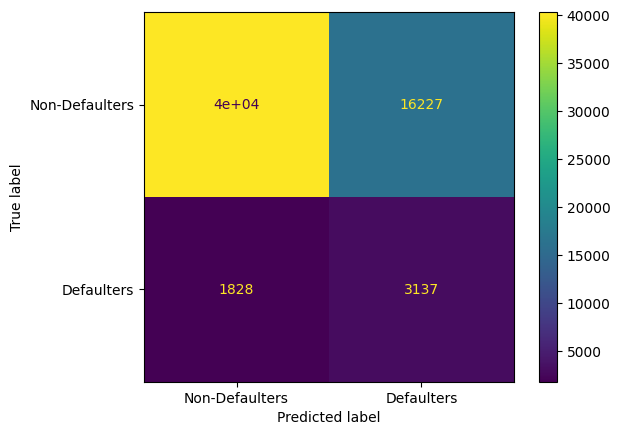

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

best_rf_cm = confusion_matrix(y_test, y_pred_best_rf)
disp = ConfusionMatrixDisplay(
    best_rf_cm,
    display_labels=['Non-Defaulters', 'Defaulters']
)
disp.plot()
plt.show()


In [14]:
from sklearn.model_selection import learning_curve
import numpy as np 
import matplotlib as plt

In [15]:
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, 
    X_train, 
    y_train, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    train_sizes = np.linspace(0.1,1,5)
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

train_mean, val_mean

(array([0.82284298, 0.79939449, 0.78852791, 0.78172041, 0.77745876]),
 array([0.72237095, 0.72895035, 0.73089139, 0.73060326, 0.73138362]))

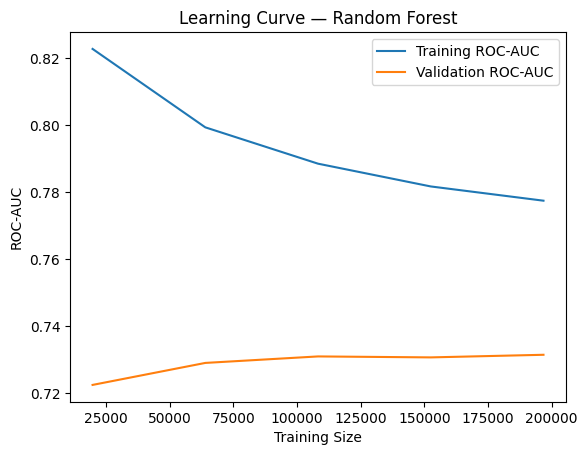

In [16]:
import matplotlib.pyplot as plt

plt.plot(train_sizes, train_mean, label='Training ROC-AUC')
plt.plot(train_sizes, val_mean, label='Validation ROC-AUC')
plt.xlabel('Training Size')
plt.ylabel('ROC-AUC')
plt.title('Learning Curve — Random Forest')
plt.legend()
plt.show()

In [17]:
y_proba_best_rf= best_rf.predict_proba(X_test)[:,1]
subset = X_test['EXT_SOURCE_3_missing'] == 1
roc_auc_score(y_test[subset], y_proba_best_rf[subset])


0.7050104733465757

In [18]:
# AMT_CREDIT
# AMT_REQ_CREDIT_BUREAU_MON
# credit_income_ratio
# employment_age_ratio

subset_1 = X_test['AMT_CREDIT'] >= 500000
print("Performance of AMT_Credit >= 500000 : ", roc_auc_score(y_test[subset_1], y_proba_best_rf[subset_1]))

subset_2 = X_test['AMT_CREDIT'] <500000
print("Performance of AMT_Credit < 500000 : ", roc_auc_score(y_test[subset_2], y_proba_best_rf[subset_2]))



Performance of AMT_Credit >= 500000 :  0.7360059649684746
Performance of AMT_Credit < 500000 :  0.7352942808711421


In [19]:
subset_3 = X_test['credit_income_ratio'] >= 3.2
subset_4 = X_test['credit_income_ratio'] <3.2
print("Performance of credit_income_ratio >= 3.2 : ", roc_auc_score(y_test[subset_3], y_proba_best_rf[subset_3]))
print("Performance of credit_income_ratio <  3.2 : ", roc_auc_score(y_test[subset_4], y_proba_best_rf[subset_4]))

Performance of credit_income_ratio >= 3.2 :  0.7320815724837353
Performance of credit_income_ratio <  3.2 :  0.7378960320169663


### Day 6 : Explainability & Model Trust
* Analysing the global feature importance


* Finding out the most important features


* Sanity check of the top features
    1. *Do the top features make domain sense?*
    2. *Are ratio features prominent?*
    3. *Are missingness features present but dominant?*
    4. *Are any non-sense features at the top?*


🚩 Red flags
* IDs or proxy identifiers
* High-cardinality noise
* One-hot explosion dominating importance

In [20]:
best_rf.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='median'))]),
                                  Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
        'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
        'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
        ...
        'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
        'AMT_REQ_CRE...
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
        'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
        'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
        'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
        'HOUSETYPE_MODE', 

In [21]:
# Global feature importance (baseline)
# This helps us understand what the model relies on overall.

# Extract feature names : 
feature_names = (
    best_rf.named_steps['preprocessor'].get_feature_names_out()
)

importances = best_rf.named_steps['classifier'].feature_importances_

fi = (
    pd.DataFrame({
        'feature' : feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
)
print(fi[fi['feature']=='num__annuity_income_ratio'], fi[fi['feature']=='num__credit_income_ratio'])
fi.head(20)

                       feature  importance
110  num__annuity_income_ratio    0.009302                       feature  importance
109  num__credit_income_ratio    0.009575


,feature,importance
30,num__EXT_SOURCE_3,0.176429
29,num__EXT_SOURCE_2,0.161262
28,num__EXT_SOURCE_1,0.064053
7,num__DAYS_BIRTH,0.043676
8,num__DAYS_EMPLOYED,0.035965
111,num__employment_age_ratio,0.028030
5,num__AMT_GOODS_PRICE,0.025957
78,num__DAYS_LAST_PHONE_CHANGE,0.023049
137,cat__NAME_EDUCATION_TYPE_Higher education,0.020237
10,num__DAYS_ID_PUBLISH,0.019011


In [22]:
print(fi[fi['feature']=='num__housing_info_missing'])
print(fi[fi['feature']=='num__EXT_SOURCE_1_missing'])
print(fi[fi['feature']=='num__EXT_SOURCE_3_missing'])
print(fi[fi['feature']=='num__Credit_info_missing'])

                       feature  importance
105  num__housing_info_missing      0.0011
                       feature  importance
106  num__EXT_SOURCE_1_missing    0.002557
                       feature  importance
107  num__EXT_SOURCE_3_missing    0.002282
                      feature  importance
108  num__Credit_info_missing      0.0023


Q : `Do the top features make domain sense ?`

A : *Yes most of the top important features are relevant as they are based on credit history, income, employment age, education, etc.*
___
Q : `Are ratio features more prominent ?`

A : *Only the employment age ratio seems to be a little prominent compared to the others at 2% compared to <1%. The most prominent ones are the credit history based features and then the age, num of days employed, age ratio and so on.*
___
Q : `Are missingess indicators present but not dominant ?`

A : *Yes, they are present but not dominant.*
___
Q : `Are any "nonsense" features present at the top ?`

A : *No, I did not find any nonsense or domain irrelevant features at the top.*


In [23]:
top_feature = fi.iloc[0]['feature']
top_feature

'num__EXT_SOURCE_3'

In [24]:
X_train_drop = X_train.drop(columns='EXT_SOURCE_3')
X_test_drop = X_test.drop(columns='EXT_SOURCE_3')

# Splitting the numerical columns and categorical columns separately for imputation 

num_cols_drop = X_train_drop.select_dtypes(include = ['int64','float64']).columns
cat_cols_drop = X_train_drop.select_dtypes(include = ['str']).columns

# Preprocessing Imputer pipelines are defined for numeric and categorical values separately

numeric_pipeline_wo_scal_drop = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_pipeline_drop = Pipeline( steps = [
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])

# Definition of the Preprocessor block using the imputer pipelines 

preprocessor_tree_drop = ColumnTransformer(
    transformers = [
        ('num', numeric_pipeline_wo_scal_drop, num_cols_drop),
        ('cat', categorical_pipeline_drop, cat_cols_drop)
    ]
)

rf_model_drop = Pipeline(steps=[
    ('preprocessor',preprocessor_tree_drop),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_leaf=100,
        n_jobs=1,
        random_state=42,        
        class_weight='balanced'
    ))
])

rf_model_drop.fit(X_train_drop, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [25]:
y_proba_drop = rf_model_drop.predict_proba(X_test)[:,1]
y_pred_drop = rf_model_drop.predict(X_test)

roc_auc_drop = roc_auc_score(y_test, y_proba_drop)
recall_drop = recall_score(y_test, y_pred_drop)
precision_drop = precision_score(y_test, y_pred_drop)
f1_drop = f1_score(y_test, y_pred_drop)

evaluation_df.loc[len(evaluation_df)] = {"model_name": "Dropeed random forest", "roc_auc": roc_auc_best_rf, "recall": recall_best_rf, "precision": precision_best_rf, "f1_score": f1_best_rf}

evaluation_df

,model_name,roc_auc,recall,precision,f1_score
0,Best_Random_Forest,0.734838,0.631823,0.162002,0.257882
1,Dropeed random forest,0.734838,0.631823,0.162002,0.257882


In [26]:
feature_names = (
    rf_model_drop.named_steps['preprocessor']
    .get_feature_names_out()
)

importances = rf_model_drop.named_steps['classifier'].feature_importances_

fi = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    .sort_values('importance', ascending=False)
)
fi

,feature,importance
29,num__EXT_SOURCE_2,0.198852
28,num__EXT_SOURCE_1,0.075657
7,num__DAYS_BIRTH,0.048291
8,num__DAYS_EMPLOYED,0.045526
110,num__employment_age_ratio,0.037816
...,...,...
221,cat__ORGANIZATION_TYPE_Services,0.000000
242,cat__HOUSETYPE_MODE_terraced house,0.000000
241,cat__HOUSETYPE_MODE_specific housing,0.000000
240,cat__HOUSETYPE_MODE_block of flats,0.000000


In [ ]:
import shap

explainer = shap.TreeExplainer(
    best_rf.named_steps['classifier']
)

X_transformed = best_rf.named_steps['preprocessor'].transform(X_test)

shap_values=explainer.shap_values(X_transformed)


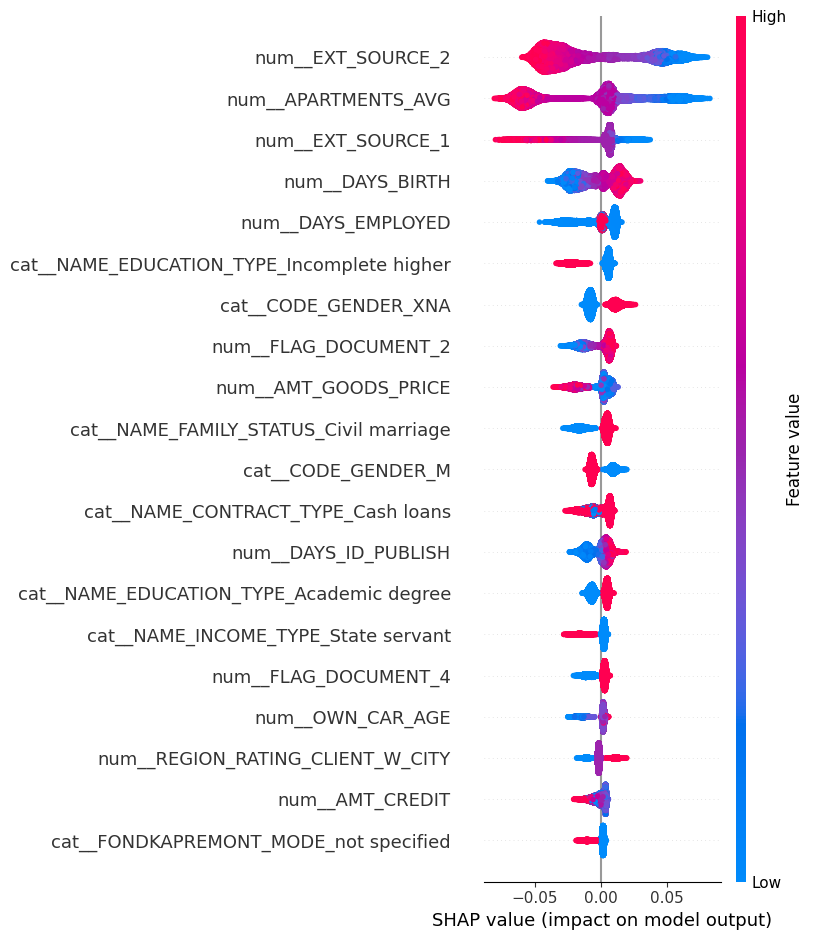

In [30]:
shap.summary_plot(
    shap_values[:,:,-1],
    X_transformed, 
    feature_names= feature_names
)

#### Day 6 Reflection (Mandatory)

Q1: Top 3 global features and why they make sense

Q2: One feature you expected to matter but didn’t

Q3: One potential risk or bias you noticed

Q4: Whether you trust this model more now — and why